
# Data Processing Example - TRKR

In [1]:
# General imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import experimentdataanalysis.analysis.dataframe_plotting as dfplot
import experimentdataanalysis.data_io.csv_to_dataframe as csv2df

In [2]:
# import jtplot submodule from jupyterthemes IF installed
import importlib
jtplot_found = importlib.util.find_spec("jupyterthemes.jtplot") is not None
if jtplot_found:
    from jupyterthemes import jtplot
    # - currently installed theme will be used to
    jtplot.style(ticks=False, grid=False, fscale=1.6)
    # set the default figure size
    jtplot.figsize(x=6., y=6.)
    # needed to avoid spurious error messages with imshow...
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


## Load data

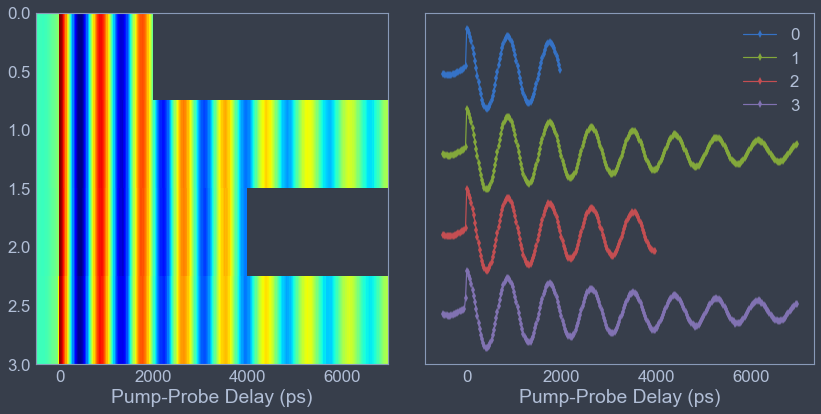

probe_delay   lockin1  lockin2  file_index  \
run_id index_2d index_1d                                               
0      0.0      0           -500.2216  0.000130 -0.02200           0   
                1           -475.2909  0.000122 -0.02742           0   
                2           -450.3601  0.000088 -0.03182           0   
                3           -425.4294  0.000033 -0.03474           0   
                4           -400.2216  0.000050 -0.03608           0   

                          b_external  wavelength  
run_id index_2d index_1d                          
0      0.0      0              200.0       836.0  
                1              200.0       836.0  
                2              200.0       836.0  
                3              200.0       836.0  
                4              200.0       836.0

In [3]:
# UNITS: 
# time: ps
# b-field: mT
# voltages: V

# REQUIRED: directory containing 2D scans
# parent_dir = ('C:\\Data\\feb2017_data_part2')
parent_dir = ('C:\\Data\\FitTrialData2\\Delay_Scan')

# REQUIRED: data storage format information
delimiter = '\t'
trailing_delimiters = True  # rows end in delimiters
num_headerlines = 0
column_names_row = 1  # NOT counting skipped lines from num_headerlines
overwriting_column_names = []

if not overwriting_column_names:
    overwriting_column_names = None
pandas_read_csv_kwargs = {
     'skiprows': num_headerlines,
     'header': column_names_row,
     'names': overwriting_column_names,
     'delimiter': delimiter,
}
if trailing_delimiters:  # needed to avoid problems
    pandas_read_csv_kwargs['index_col'] = False

# REQUIRED: filename key for data files, will load only these
filename_key = '.dat'

# REQUIRED: criteria for grouping runs
run_criteria = 'directory'

# OPTIONAL: filepath parsing rules
# DEFAULT SEARCH TERMS AND SEARCH RULES:
# 1. If first string found, register second string as
#    tag containing third string/value
#        e.g. if keyword_list contains ("warmup", "Warmup?", "Yes"):
#             "...warmup..." -> {"Warmup?": "Yes"}
this_element_keyword_list = [
    (       "CISP", "Experiment Type", "CISP"       ),
    ( "Delay_Scan", "Experiment Type", "Delay_Scan" ),
    ( "Field_Scan", "Experiment Type", "Field_Scan" ),
    ("Mirror_Scan", "Experiment Type", "Mirror_Scan"),
    ( "RMBE1130-K", "Sample ID", "RMBE1130-K"),
    ("[1-10]Horiz", "Sample Orientation", "[1-10]Horiz"),
]
# 2. Grab next element(s) if this one CONTAINS first string,
#    tag next element(s) as second string(s)
#        e.g. "..._Ind_3_..." -> {"FastScanIndex": 3}
#        e.g. "..._2Dscan_MirrorY_MirrorZ_..."
#                 -> {"SecondScanType": "MirrorY",
#                     "FirstScanType": "MirrorZ"}
next_element_keyword_list = []
# 3. Grab this element if it CONTAINS first string,
#    tag remainder as second string
#        e.g. "..._30K_..." -> {"SetTemperature": 30}
in_this_element_keyword_list = [
    ("FIELD", "Date_and_Scan_2D_Index"),
    ("DLAY", "Date_and_Scan_2D_Index"),
    ("STPR", "Date_and_Scan_2D_Index"),
    ("phi-", "Electric Field Angle"),
    ("T", "Magnetic Field (T)"),
    ("K", "Set Temperature (K)"),
    ("nm", "Wavelength (nm)"),
    ("ps", "Delay Time (ps)"),
    ("V", "Voltage (V)"),
]
parsing_keyword_lists = [this_element_keyword_list,
                         next_element_keyword_list,
                         in_this_element_keyword_list]

# OPTIONAL: metadata processing functions,
# must accept dict and modify in-place
def derive_metadata_from_scan_type_tag(metadata_dict):
    if 'Date_and_Scan_2D_Index' in metadata_dict.keys():
        date_and_index = str(metadata_dict['Date_and_Scan_2D_Index'])
        metadata_dict['Date'] = date_and_index[:6]
        metadata_dict['Scan_2D_Index'] = float(date_and_index[6:]) - 1
        del metadata_dict['Date_and_Scan_2D_Index']
def consolidate_aliases_for_bfield(metadata_dict):
    if 'Magnetic Field (T)' in metadata_dict.keys():
        metadata_dict['Magnetic Field (mT)'] = \
            1000.0 * metadata_dict['Magnetic Field (T)']
metadata_processing_fcns = [derive_metadata_from_scan_type_tag,
                            consolidate_aliases_for_bfield]

# OPTIONAL: metadata-based filtering fcns, type: dict() -> bool
# fcns returning False if data should be ignored
metadata_filter_fcns = [
#     lambda metadata_dict: metadata_dict.get("# repeats", 1) <= 2,
    lambda metadata_dict: "alignment" not in metadata_dict.get("Filepath"),
    lambda metadata_dict: "Scan_2D_Index" in metadata_dict.keys(),
]

# OPTIONAL: metadata tags to be converted to dataframe columns.
# Elements should be of form ('metadata tag', 'column name')
metadata_tag_to_column_list = [
    (             'Run ID', 'run_id'),
    (      'Scan_2D_Index', 'index_2d'),
    ('Magnetic Field (mT)', 'b_external'),
    (    'Wavelength (nm)', 'wavelength'),
]

# OPTIONAL: dataframe processing functions,
# must accept dataframe and modify in-place
def set_dataframe_indices(df):
    df['index_1d'] = df.index  # assumes index = 0,1,2,...  
    df.set_index(['run_id', 'index_2d', 'index_1d'],
                 drop=True, append=False, inplace=True)
def edit_dataframe_colnames(df):
    renaming_dict = {}
    if 'Delay (ps)' in list(df):
        renaming_dict['Delay (ps)'] = 'probe_delay'
    if 'Lock-In 1 (V)' in list(df):
        renaming_dict['Lock-In 1 (V)'] = 'lockin1'
    if 'Lock-In 2 (V)' in list(df):
        renaming_dict['Lock-In 2 (V)'] = 'lockin2'
    df.rename(columns=renaming_dict, inplace=True)
dataframe_processing_fcns = [
    set_dataframe_indices,
    edit_dataframe_colnames,
]

filepath_list, file_dataframes_list, file_metadata_list = \
    csv2df.process_directory_csvs_to_dataframes(
        parent_dir, filename_key, run_criteria,
        pandas_read_csv_kwargs,
        parsing_keyword_lists,
        metadata_processing_fcns,
        metadata_filter_fcns,
        metadata_tag_to_column_list,
        dataframe_processing_fcns)

full_dataframe = pd.concat(file_dataframes_list)
full_dataframe.sort_index(ascending=True, inplace=True)

# plot newly created dataframe and show the first few rows
figure_size = (12, 6)
num_waterfall_plots = 4
data_column = 'lockin2'
x_values_column = 'probe_delay'
y_values_column = None
xlabel = 'Pump-Probe Delay (ps)'
ylabel = None
imshow_kwargs = {'aspect': 1.0,
                 'origin': 'upper'}
plt.figure(figsize=figure_size)
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
dfplot.plot_dataframe_colorplot(full_dataframe, data_column,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=ylabel,
                                ax=ax1, **imshow_kwargs)
dfplot.plot_dataframe_waterfall(full_dataframe, data_column,
                                num_waterfall_plots,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=None, ax=ax2)
ax2.yaxis.set_ticklabels([])
plt.show()
full_dataframe.head(5)

In [4]:
# TAKE A LOOK AT ANY SUBFILE
file_index = 0
for key, val in file_metadata_list[file_index].items():
    print("{}: {}".format(key, val))
file_dataframes_list[file_index].head()

Filepath: C:\Data\FitTrialData2\Delay_Scan\170606DLAY01 Delay_Scan RMBE1130-K_30K_836nm_[1-10]Horiz_0.2T.dat
Scan_2D_Index: 0.0
Magnetic Field (T): 0.2
Wavelength (nm): 836.0
Sample Orientation: [1-10]Horiz
Date: 170606
File Last Modified: Tue Jun 13 16:16:40 2017
Run ID: 0
Set Temperature (K): 30.0
Magnetic Field (mT): 200.0
Sample ID: RMBE1130-K


probe_delay   lockin1  lockin2  file_index  \
run_id index_2d index_1d                                               
0      0.0      0           -500.2216  0.000130 -0.02200           0   
                1           -475.2909  0.000122 -0.02742           0   
                2           -450.3601  0.000088 -0.03182           0   
                3           -425.4294  0.000033 -0.03474           0   
                4           -400.2216  0.000050 -0.03608           0   

                          b_external  wavelength  
run_id index_2d index_1d                          
0      0.0      0              200.0       836.0  
                1              200.0       836.0  
                2              200.0       836.0  
                3              200.0       836.0  
                4              200.0       836.0

In [5]:
# # EXAMPLE - REORDERING AXES
# df = full_dataframe
# df = df.groupby(level=[-3, -2]).head(5)
# new_index = df.index.reorder_levels([-2, -3, -1])
# df.index = new_index
# df

## Pandas-lmfit helper functions

In [6]:
from experimentdataanalysis.analysis.dataframe_processing \
    import df_extract_dataset_indexed_matrices, \
           df_extract_vector_lists_by_dataset, \
           df_transform_dataset_df_to_fit_row, \
           df_minimize_fcn_on_datasets, \
           df_minimize_fcn_across_linked_datasets
from experimentdataanalysis.analysis.fit_tools \
    import create_residuals_fcn

# df_extract_dataset_indexed_matrices(df, column_names)
# df_extract_vector_lists_by_dataset(df, column_names)
# df_transform_dataset_df_to_fit_row(df, group_fit_params_dict,
#                                    fit_params_to_add,
#                                    column_aggregation_dict={},
#                                    keep_const_columns=True)
# df_minimize_fcn_on_datasets(df, residuals_fcn, fit_params,
#                             independent_vars_columns,
#                             measured_data_column,
#                             *res_args,
#                             column_aggregation_dict={},  # KEYWORDS ONLY!
#                             keep_const_columns=True,
#                             **res_kwargs)

# WORK IN PROGRESS:
# df_minimize_fcn_across_linked_datasets(df, residuals_fcn, fit_params,
#                                        dataset_params_unpacking_fcn,
#                                        independent_vars_columns,
#                                        measured_data_column,
#                                        *res_args,
#                                        column_aggregation_dict={},  # KEYWORDS ONLY!
#                                        keep_const_columns=True,
#                                        **res_kwargs)

## Dataset fit model and residuals

In [7]:
# GLOBAL CONSTANTS
GFACTORCONSTANT = 1.3996e-5  # 1/(ps*mTesla), = bohr magneton/2*pi*hbar
LASER_REPRATE = 13158  # ps period

from experimentdataanalysis.simulations.simple_trkr_rsa_simulation \
    import trkr_decaying_cosine

auto_residuals_trkr_decaying_cosine = \
    create_residuals_fcn(trkr_decaying_cosine,
                         ['delay_time', 'total_bfield'])

# def residuals_trkr_decaying_cosine(params,
#                                    delay_time, total_bfield,
#                                    measured_data=None):
#     # unpack parameters:
#     #  extract .value attribute for each parameter
#     param_values = params.valuesdict()
#     gfactor      = param_values['gfactor']
#     amplitude    = param_values['amplitude']
#     phase_offset = param_values['phase_offset']
#     y_offset     = param_values['y_offset']
#     result = trkr_decaying_cosine(
#                 delay_time, total_bfield,  # <-independent vars
#                 pulse_amplitude,  # <- params to unpack
#                 gfactor, spin_lifetime,
#                 initial_phase, extra_phase_offset,
#                 slope, offset)
#     if measured_data is None:
#         return result
#     return result - measured_data

## Dataset fit parameter setup and constraints

In [8]:
from lmfit import Parameters

params_guesses = [('pulse_amplitude',     {'value' : 1e-3,
                                           'min'   : 0.0,
                                           'max'   : 1.0}),
                  ('gfactor',             {'value' : 0.40,
                                           'min'   : 0.35,
                                           'max'   : 0.50,
                                           'vary'  : True}),
                  ('spin_lifetime',       {'value' : 2000.0,
                                           'min'   : 0.0,
                                           'max'   : 1e5}),
                  ('initial_phase',       {'value' : 0.0,
                                           'vary'  : False}),
                  ('extra_phase_offset',  {'value' : 0.0,
                                           'min'   : -np.pi,
                                           'max'   : +np.pi}),
                  ('slope',               {'value' : 0.0,
                                           'min'   : -1e-2,
                                           'max'   : +1e-2}),
                  ('offset',              {'value' : 0.0,
                                           'min'   : -1e-2,
                                           'max'   : +1e-2}),
                 ]
fit_params = Parameters()
for param_name, param_guess_dict in params_guesses:
    fit_params.add(param_name, **param_guess_dict)

## 1D Fit to fake data

,file_index,b_external,wavelength,pulse_amplitude,pulse_amplitude_error,gfactor,gfactor_error,spin_lifetime,spin_lifetime_error,initial_phase,extra_phase_offset,extra_phase_offset_error,slope,slope_error,offset,offset_error
index_2d,,,,,,,,,,,,,,,,
0.0,0.0,200.0,836.00,0.386819,0.008851,0.405162,0.000924,7517.226139,857.867390,0.0,0.059266,0.025113,-8.937828e-06,6.912700e-06,0.010000,0.007360
1.0,1.0,200.0,836.00,0.410003,0.005446,0.404725,0.000278,4945.875900,120.927935,0.0,0.063383,0.013178,-7.896465e-07,6.317701e-07,0.006159,0.002477
2.0,2.0,200.0,836.00,0.408352,0.001084,0.404369,0.000084,5039.222647,35.580412,0.0,0.064599,0.002788,-1.221752e-07,2.570474e-07,0.001602,0.000560
3.0,3.0,200.0,836.17,0.392691,0.005408,0.405171,0.000289,4934.963889,124.821427,0.0,0.070988,0.013674,-7.553231e-07,6.272968e-07,0.006618,0.002459


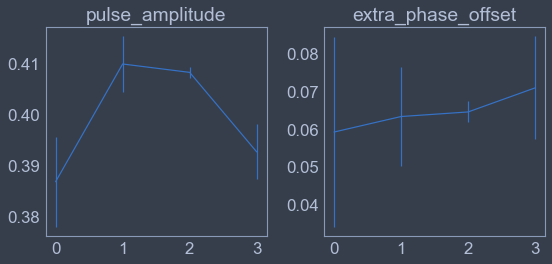

In [9]:
df = full_dataframe.xs(0, level='run_id')
fit_output_df = df
residuals_fcn = auto_residuals_trkr_decaying_cosine
fit_params = fit_params
independent_vars_columns = ["probe_delay", "b_external"]
measured_data_column = "lockin2"
fit_params_to_add = ['amplitude', 'phase_offset']
column_aggregation_dict = {'time_elapsed': lambda x: x.head(1).values}  # keep first time
keep_const_columns = True

minimize_results, results_df = \
    df_minimize_fcn_on_datasets(df, residuals_fcn, fit_params,
                                independent_vars_columns,
                                measured_data_column,
                                column_aggregation_dict=column_aggregation_dict,  # keywords only!
                                keep_const_columns=keep_const_columns)

# FILTER OUT BAD FITS
good_result_indices = []
for dataset_index, result in enumerate(minimize_results):
    red_flag = False
    if result.params['extra_phase_offset'].stderr > np.pi / 2:
        print("dataset {}: ".format(dataset_index) +
              "phase offset error too large, ignoring dataset...")
        red_flag = True
    if not red_flag:
        good_result_indices.append(dataset_index)
#        fit_output_df[measured_data_column].iloc[dataset_index] = \
            
trimmed_results_df = results_df.iloc[good_result_indices]
trimmed_minimize_results = [minimize_results[ind]
                            for ind in good_result_indices]

plt.figure(figsize=(8,4))
ax1 = plt.subplot(1,2,1)
plt.errorbar(x=trimmed_results_df.index,
             y=trimmed_results_df.pulse_amplitude,
             yerr=trimmed_results_df.pulse_amplitude_error)
# new_df['amplitude'].plot.line(ax=ax1)
plt.title('pulse_amplitude')
ax2 = plt.subplot(1,2,2)
plt.errorbar(x=trimmed_results_df.index,
             y=trimmed_results_df.extra_phase_offset,
             yerr=trimmed_results_df.extra_phase_offset_error)
# new_df['phase_offset'].plot.line(ax=ax2)
plt.title('extra_phase_offset')
results_df.head(5)


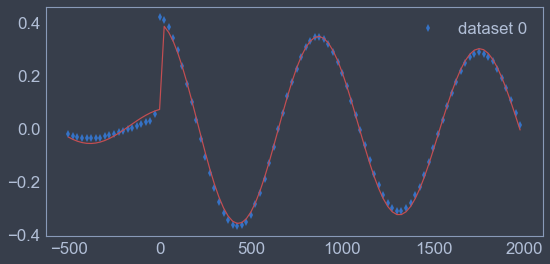

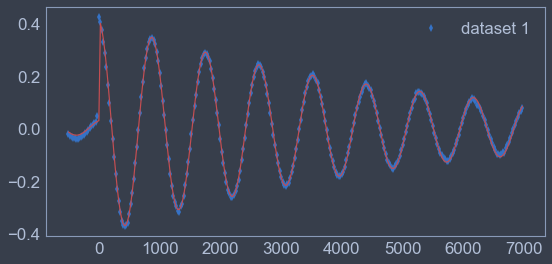

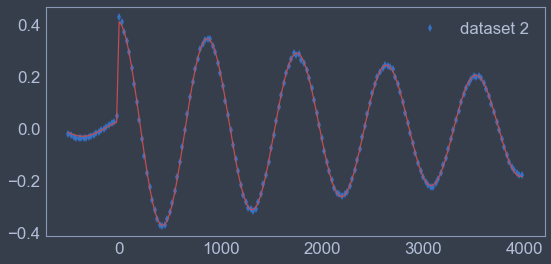

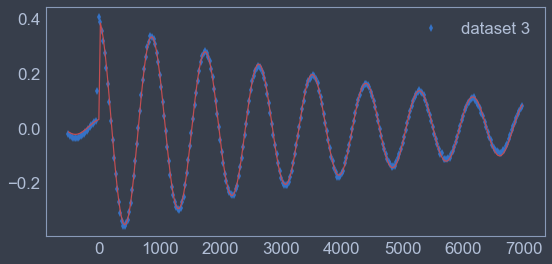

In [10]:
# PLOT FIT RESULTS
result_indices_to_plot = [0, 1, 2, 3]
for result_index in result_indices_to_plot:
    dataset_index_2d = np.int(results_df.index[result_index])
    result = minimize_results[dataset_index_2d]
    xvals = df.loc[dataset_index_2d].probe_delay
    yvals = df.loc[dataset_index_2d].lockin2
    fit_yvals = residuals_fcn(result.params,
                              df.loc[dataset_index_2d].probe_delay,
                              df.loc[dataset_index_2d].b_external)
    plt.figure(figsize=(8,4))
    plt.plot(xvals, yvals, 'bd', label='dataset {}'.format(result_index))
    plt.plot(xvals, fit_yvals, 'r')
    plt.legend()